# Problem 1: scraping houses prices

## Strategy
Loop over all the pages.
For each page, loop over all the list items: 
```html
<li class="sold-results__normal-hit">
  ...
</li>
```
For each list item, extract the following information:
### Sold date: 
```html
<span class="hcl-label hcl-label--state hcl-label--sold-at">
    Såld 9 oktober 2023
</span>
```
remove the "Såld " prefix

### Address: 
```html
<h2 class="sold-property-listing__heading qa-selling-price-title hcl-card__title">
  Skårby station 350
</h2>
```
### Location of the estate: 
```html
   <div class="sold-property-listing__location">
     <div>
       <span class="property-icon property-icon--result">...</span>
       Kareby,
       Kungälvs kommun
     </div>
   </div>
```
access the div child and remove the span element

### Area of the house & number of rooms:
```html  
<div class="sold-property-listing__subheading sold-property-listing__area">
    143
      <span class="listing-card__attribute--normal-weight">
        + 25&nbsp;m²
      </span>
    &nbsp;
    7&nbsp;rum
</div>
```
OR
```html
<div class="sold-property-listing__subheading sold-property-listing__area">
  123&nbsp;m²
  &nbsp;
  6&nbsp;rum
</div>
```
remove the span element if present, remove the m² and rum suffixes
save the biarea if a "+" is present

### Area of the plot:
```html
<div class="sold-property-listing__land-area">
  2&nbsp;963&nbsp;m² tomt
</div>
```
remove the m² tomt suffix

### Closing price:
```html
<span class="hcl-text hcl-text--medium">
  Slutpris 4&nbsp;395&nbsp;000&nbsp;kr
</span>
```
remove the "Slutpris " prefix and the kr suffix
  
---

In [53]:
import glob
import math
from datetime import datetime

from bs4 import BeautifulSoup
import re

import csv	
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Loop over all the pages.

In [41]:
file_pattern = "kungalv_slutpriser/kungalv_slutpris_page_*.html"

swedish_to_english_months = {
	'januari': 'January', 'februari': 'February', 'mars': 'March',
	'april': 'April', 'maj': 'May', 'juni': 'June',
	'juli': 'July', 'augusti': 'August', 'september': 'September',
	'oktober': 'October', 'november': 'November', 'december': 'December'
}

data_dict = []

for file_name in glob.glob(file_pattern):
	with open(file_name, "r") as f:
		content = f.read()
		soup = BeautifulSoup(content, "html.parser")
		print("Processing", file_name, "...")
		for li in soup.find_all("li", class_="sold-results__normal-hit"):
			
			# Sold date
			sold_date_element = li.find("span", class_="hcl-label hcl-label--state hcl-label--sold-at")
			if sold_date_element is not None:
				sold_date = (
					sold_date_element.text
					.replace("Såld ", "")
					.strip()
				)
				for swedish_month, english_month in swedish_to_english_months.items():
					sold_date = sold_date.replace(swedish_month, english_month)
				sold_date = datetime.strptime(sold_date, '%d %B %Y')

			# Address
			address_element = li.find("h2", class_="sold-property-listing__heading qa-selling-price-title hcl-card__title")
			if address_element is not None:
				address = (
					address_element.text
					.strip()
				)

			# Location
			location_element = li.find("div", class_="sold-property-listing__location").div
			if location_element is not None:
				location_element.find("span").decompose()
				location = re.sub(
					r'\n\s+',
					" ",
					location_element.text.strip(),
				)

			area_element = li.find("div", class_="sold-property-listing__subheading sold-property-listing__area")
			if area_element is not None:
				if area_element.find("span") is not None:
					biarea = float(
						area_element
						.find("span").text
						.replace("\u00a0", "")
						.replace("m²", "")
						.replace("+ ", "")
						.replace(",", ".")
						.strip()
					)
					area_element.find("span").decompose()
				else:
					biarea = None
				values = (
					area_element.text
					.replace("\u00a0m²", "")
					.replace("\u00a0rum", "")
					.split("\u00a0")
				)
				values = [
					float(v.replace(",", ".").strip())
					for v in values
					if re.match(
						r'^-?\d+(?:\.\d+)?$',
						v.replace(",", ".").strip()
					) is not None
				]
				boarea, rooms = (values + [None, None])[:2]
				rooms = int(rooms) if rooms is not None else None

			# Plot
			plot_element = li.find("div", class_="sold-property-listing__land-area")
			plot = None
			if plot_element is not None:
				plot = float(
					plot_element.text
					.replace("\u00a0", "")
					.replace("m² tomt", "")
					.replace(",", ".")
					.strip()
				)

			# Price
			price_element = li.find("span", class_="hcl-text hcl-text--medium")
			price = None
			if price_element is not None:
				price = float(
					price_element.text
					.replace("\u00a0", "")
					.replace("Slutpris ", "")
					.replace("kr", "")
					.replace(",", ".")
					.strip()
				)

			data_dict.append({
				"sold_date": sold_date,
				"address": f'"{address}"',
				"location": f'"{location}"',
				"boarea": boarea,
				"biarea": biarea,
				"rooms": rooms,
				"plot": plot,
				"price": price,
			})

with open("housing_data.csv", "w") as f:
	f.write(",".join(data_dict[0].keys()) + "\n")
	for data in data_dict:
		f.write(",".join(str(v) for v in data.values()) + "\n")

Processing kungalv_slutpriser/kungalv_slutpris_page_27.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_31.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_11.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_07.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_06.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_10.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_30.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_26.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_40.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_17.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_01.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_21.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_37.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_36.html ...
Processing kungalv_slutpriser/kungalv_slutpris_page_20.html ...
Processing kungalv_slutpriser/kungalv_sl

# Problem 2: Analyzing 2022 house sales

In [42]:
import pandas as pd

In [43]:
df = pd.read_csv("housing_data.csv")
df.describe()

,boarea,biarea,rooms,plot,price
count,1962.000000,1074.000000,1909.000000,1947.000000,1.973000e+03
mean,122.395668,53.125605,4.972761,2124.659271,4.233211e+06
std,41.709399,37.856330,1.451989,11915.230625,1.657449e+06
min,4.000000,1.000000,1.000000,108.000000,2.500000e+05
25%,98.000000,21.000000,4.000000,681.000000,3.200000e+06
50%,122.000000,48.000000,5.000000,1069.000000,4.100000e+06
75%,146.750000,75.000000,6.000000,1649.000000,5.035000e+06
max,326.000000,231.000000,12.000000,479907.000000,2.100000e+07


In [44]:
closing_price_list = df["price"].dropna().tolist()
closing_price_list

[3100000.0,
 3850000.0,
 4000000.0,
 3200000.0,
 8800000.0,
 4375000.0,
 10800000.0,
 1875000.0,
 3000000.0,
 4300000.0,
 4500000.0,
 4950000.0,
 2425000.0,
 2475000.0,
 4780000.0,
 7900000.0,
 1650000.0,
 7160000.0,
 5475000.0,
 3965000.0,
 4150000.0,
 2495000.0,
 1600000.0,
 3400000.0,
 3700000.0,
 2670000.0,
 4150000.0,
 3700000.0,
 4100000.0,
 4100000.0,
 2700000.0,
 3250000.0,
 4000000.0,
 2800000.0,
 2710000.0,
 4575000.0,
 3650000.0,
 5875000.0,
 4950000.0,
 4325000.0,
 4575000.0,
 7150000.0,
 4555000.0,
 2800000.0,
 4820000.0,
 3550000.0,
 3295000.0,
 5300000.0,
 3450000.0,
 2500000.0,
 4725000.0,
 2100000.0,
 4400000.0,
 3100000.0,
 1150000.0,
 2550000.0,
 4850000.0,
 4300000.0,
 3250000.0,
 4750000.0,
 4560000.0,
 3500000.0,
 3425000.0,
 2800000.0,
 2730000.0,
 2840000.0,
 3325000.0,
 4700000.0,
 2050000.0,
 4000000.0,
 8700000.0,
 5700000.0,
 3550000.0,
 3025000.0,
 11250000.0,
 3500000.0,
 3300000.0,
 4000000.0,
 5355000.0,
 4200000.0,
 6000000.0,
 1075000.0,
 2900000.0,
 2

In [45]:
# Function to calculate the five-number summary
def five_number_summary(data):
	minimum = np.min(data)
	maximum = np.max(data)
	median = np.median(data)
	q1 = np.percentile(data, 25)
	q3 = np.percentile(data, 75)
	return minimum, q1, median, q3, maximum

In [46]:
min_val, q1, median, q3, max_val = five_number_summary(closing_price_list)
print(min_val, q1, median, q3, max_val)

250000.0 3200000.0 4100000.0 5035000.0 21000000.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

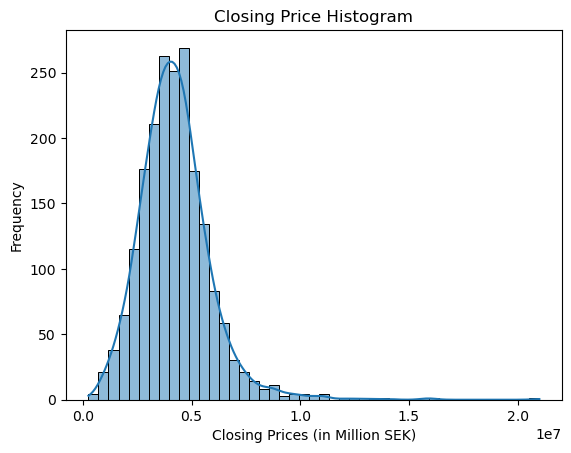

In [60]:
sns.histplot(closing_price_list, kde=True, bins=math.ceil(len(closing_price_list)**0.5))
plt.title("Closing Price Histogram")
plt.xlabel("Closing Prices (in Million SEK)")
plt.ylabel("Frequency")

Text(0, 0.5, 'Boarea (m²)')

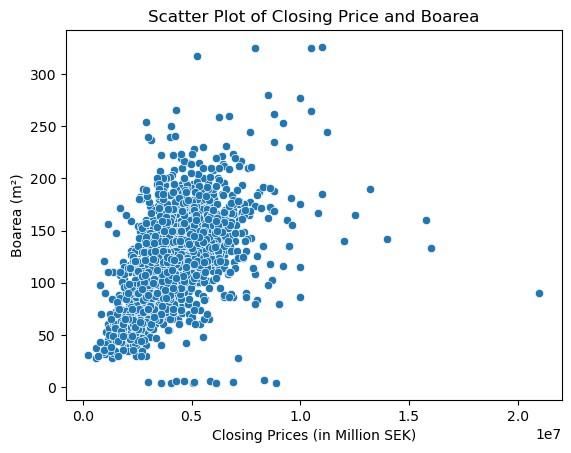

In [62]:
sns.scatterplot(x="price", y="boarea", data=df)
plt.title("Scatter Plot of Closing Price and Boarea")
plt.xlabel("Closing Prices (in Million SEK)")
plt.ylabel("Boarea (m\u00B2)")

Text(0, 0.5, 'Boarea (m²)')

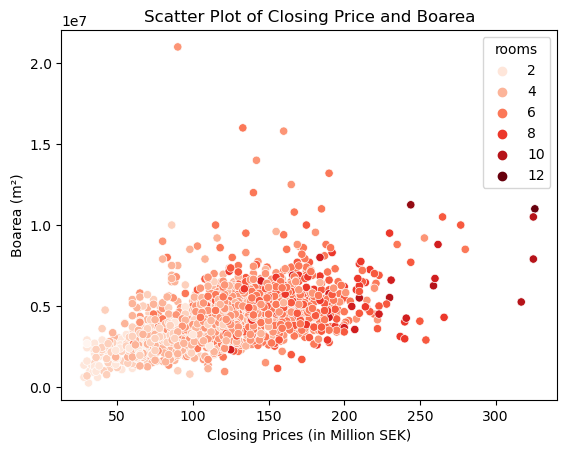

In [63]:
sns.scatterplot(x="boarea", y="price", hue="rooms", data=df, palette="Reds")
plt.title("Scatter Plot of Closing Price and Boarea")
plt.xlabel("Closing Prices (in Million SEK)")
plt.ylabel("Boarea (m\u00B2)")